In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern,ConstantKernel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
#%%
# INDOORS 1 SUN AIR 
file = pd.ExcelFile('Indoor MPP_1.0 sun_Air_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column



# print(time)
time_series_1_air_sun = []
for i in range (temperature.shape[0]):
    time_series_1_air_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_air_sun = np.array(time_series_1_air_sun) # convert it to array [shape(24, 4001)]

# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column



# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]


# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]



# %%
# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding

time_series_1_air_sun_shape = time_series_1_air_sun.shape
time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_air_sun = np.pad(time_series_1_air_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_air_sun.shape[1])),mode='edge')    
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_air_sun = np.reshape(time_series_1_air_sun, ((time_series_1_air_sun.shape[0],time_series_1_air_sun.shape[1],1)))
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
 

In [3]:
# Calculate average values for time_series_1_sun_air
time_series_1_air_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_air_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_air_sun_average[j] = np.mean(time_series_1_air_sun[i-1:i+1], axis=0)
        j += 1


# Calculate average values for time_series_1_sun
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
outdoor_conditions_stacked_2= np.stack([outdoor_conditions] * 20, axis=0)

 

In [5]:
import pywt
import numpy as np
import matplotlib.pyplot as plt



wavelet = 'db10'  # Use the 'db2' wavelet
scales = np.arange(1, 10)  # Define the range of scales for the CWT
wavelets_coeffs_input1 = np.zeros((12, 4794, 10))
wavelets_freq_input1 = np.zeros((12, 4794, 10))
wavelets_coeffs_input2 = np.zeros((12, 4794, 10))
wavelets_freq_input2 = np.zeros((12, 4794, 10))
wavelets_coeffs_output = np.zeros((12, 4794, 10))
wavelets_freq_output= np.zeros((12, 4794, 10))
 

for i in range(12):
    coeffs, freqs = pywt.dwt(time_series_1_air_sun_average[i],   wavelet)
    power = (np.abs(coeffs))**2  # Compute the power of CWT coefficients
    wavelets_coeffs_input1[i] = coeffs
    wavelets_freq_input1[i] = freqs
for i in range(12):
    coeffs, freqs = pywt.dwt(time_series_1_sun_average[i],   wavelet)
    power = (np.abs(coeffs))**2  # Compute the power of CWT coefficients
    wavelets_coeffs_input2[i] = coeffs
    wavelets_freq_input2[i] = freqs
for i in range(12):
    coeffs, freqs = pywt.dwt(outdoor_panels_power_average[i],   wavelet)
    power = (np.abs(coeffs))**2  # Compute the power of CWT coefficients
    wavelets_coeffs_output[i] = coeffs
    wavelets_freq_output[i] = freqs
y_pred2 = pywt.idwt(coeffs, freqs, wavelet)


In [6]:
'''all_new_features = np.concatenate((time_series_1_sun_average, wavelets ,outdoor_conditions_stacked), axis=2)# concatenate the input for the model
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)'''
input = np.concatenate((wavelets_coeffs_input1,wavelets_freq_input1,wavelets_coeffs_input2,wavelets_freq_input2), axis=2)
output = np.concatenate((wavelets_coeffs_output,wavelets_freq_output), axis=2)



In [9]:
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct 
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.covariance import EllipticEnvelope
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer 
from skopt import gp_minimize
# Specify the number of samples
num_samples =input.shape[0]

# Reshape the data to have the shape (num_samples, num_features)
input_reshaped = input.reshape(num_samples, -1)
output_reshaped = output.reshape(num_samples, -1)




# Define the number of folds for cross-validation
num_folds = 12

# Initialize lists to store the average MSE for each fold
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 47940))
y_pred2=np.zeros(( 1, 47940))
# Initialize arrays to store the predictions and test data for each fold
predictions1 = np.zeros((12, 4794, 2))
test1= np.zeros((12, 4794, 2))
predictions2 = np.zeros((12, 4794, 2))
test2 = np.zeros((12, 4794, 2))
# Perform k-fold cross-validation

 

for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]

    # Split the data into training and test sets for the current fold
    X_train, X_test = input_reshaped [train_index], input_reshaped [test_index]
    y_train, y_test = output_reshaped[train_index], output_reshaped[test_index]
    scaler = StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    param_space = {
        'kernel': Categorical(['linear', 'rbf', 'poly']),
        'alpha': Real(0.001, 20.0, prior='log-uniform'),  # Expanded alpha range from 0.001 to 10.0
        'gamma': Real(0.0001, 20.0, prior='log-uniform'),  # Expanded gamma range from 0.0001 to 10.0
        'degree': Integer(1, 5),  # Expanded degree range from 1 to 5
        'coef0': Real(-2.0, 2.0),  # Expanded coef0 range from -1.0 to 1.0
    }

    # Define the objective function to optimize (MSE in this case)
    def objective_function(params):
        kernel = params[0]
        alpha = params[1]
        gamma = params[2]
        degree = params[3]
        coef0 = params[4]

        # Create the KRR model with the given hyperparameters
        krr_model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, degree=degree, coef0=coef0)

        # Fit the model on the training data
        krr_model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = krr_model.predict(X_test)

        # Calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)

        # Negative sign as we want to minimize MSE, and skopt maximizes the objective function
        return mse

    # Perform Bayesian optimization with gp_minimize using Gaussian Process Regression
    result = gp_minimize(
        objective_function,
        dimensions=list(param_space.values()),
        n_calls=100,  # Number of function calls (adjust as needed)
        random_state=42,

        verbose=0
    )

    # Get the best hyperparameters from the optimization results
    best_params = dict(zip(param_space.keys(), result.x))
    print("Best Hyperparameters for Fold {}: {}".format(fold + 1, best_params))
    
    # Create the KRR model with the best hyperparameters
    best_krr_model = KernelRidge(**best_params)


 
    best_krr_model.fit(X_train, y_train)

 


    y_pred1 = best_krr_model.predict(X_test[0].reshape(1, -1))
    y_pred2 = best_krr_model.predict(X_test[1].reshape(1, -1))
    y_pred1=y_pred1.reshape(1, 4794, 20)
    y_pred2=y_pred2.reshape(1, 4794, 20)
    
 
    y_test1=y_test[0].reshape(1, 4794, 20)
    y_test2=y_test[1].reshape(1, 4794, 20)

    y_pred1 = pywt.idwt(cA=y_pred1[:, :, :10], cD=y_pred1[:, :, 10:], wavelet=wavelet)
    y_pred2 = pywt.idwt(y_pred2[:, :, :10], y_pred2[:, :, 10:], wavelet)
    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    y_test1 = pywt.idwt(y_test1[:, :, :10], y_test1[:, :, 10:], wavelet)
    y_test2= pywt.idwt(y_test2[:, :, :10], y_test2[:, :, 10:], wavelet)
    print(y_test1.shape)
    print(y_pred1.shape)
    test1[fold] = y_test1
    test2[fold] = y_test2
    # Calculate the Mean Squared Error for the current fold
    error1 = mean_squared_error(y_test1.reshape(1,-1), y_pred1.reshape(1,-1))
    error2= mean_squared_error(y_test2.reshape(1,-1), y_pred2.reshape(1,-1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))

    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break

# Calculate the average MSE across all folds
average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")


 
#1.03

C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Best Hyperparameters for Fold 1: {'kernel': 'poly', 'alpha': 0.001, 'gamma': 0.00036747788573107286, 'degree': 3, 'coef0': 1.1979123529995106}
(1, 4794, 2)
(1, 4794, 2)
Fold 1 - Mean Squared Error: 0.34537256468783795
Fold 1 - Mean Squared Error: 0.1454037518316537
Best Hyperparameters for Fold 2: {'kernel': 'poly', 'alpha': 20.0, 'gamma': 0.29418730272426097, 'degree': 2, 'coef0': -2.0}
(1, 4794, 2)
(1, 4794, 2)
Fold 2 - Mean Squared Error: 2.064317196067027
Fold 2 - Mean Squared Error: 2.9078264538408476


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 3: {'kernel': 'poly', 'alpha': 2.9668046463863553, 'gamma': 0.0001, 'degree': 1, 'coef0': 2.0}
(1, 4794, 2)
(1, 4794, 2)
Fold 3 - Mean Squared Error: 1.3558931661010685
Fold 3 - Mean Squared Error: 0.4183876911540595


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.31776e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Best Hyperparameters for Fold 4: {'kernel': 'poly', 'alpha': 20.0, 'gamma': 0.0001, 'degree': 1, 'coef0': 2.0}
(1, 4794, 2)
(1, 4794, 2)
Fold 4 - Mean Squared Error: 0.5141420625432807
Fold 4 - Mean Squared Error: 0.41963650863520174


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Hyperparameters for Fold 5: {'kernel': 'poly', 'alpha': 0.3863315565001478, 'gamma': 0.00015906922360067106, 'degree': 1, 'coef0': 0.10066661846656766}
(1, 4794, 2)
(1, 4794, 2)
Fold 5 - Mean Squared Error: 0.17197160102406667
Fold 5 - Mean Squared Error: 1.689810031782874


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Best Hyperparameters for Fold 6: {'kernel': 'poly', 'alpha': 0.0028901647480720724, 'gamma': 0.0006499678956363095, 'degree': 4, 'coef0': 0.12922821838701148}
(1, 4794, 2)
(1, 4794, 2)
Fold 6 - Mean Squared Error: 0.8176759608506096
Fold 6 - Mean Squared Error: 1.4814629746044023
Average Mean Squared Error: 0.8782287585456484
Average Mean Squared Error: 1.1770879019748397


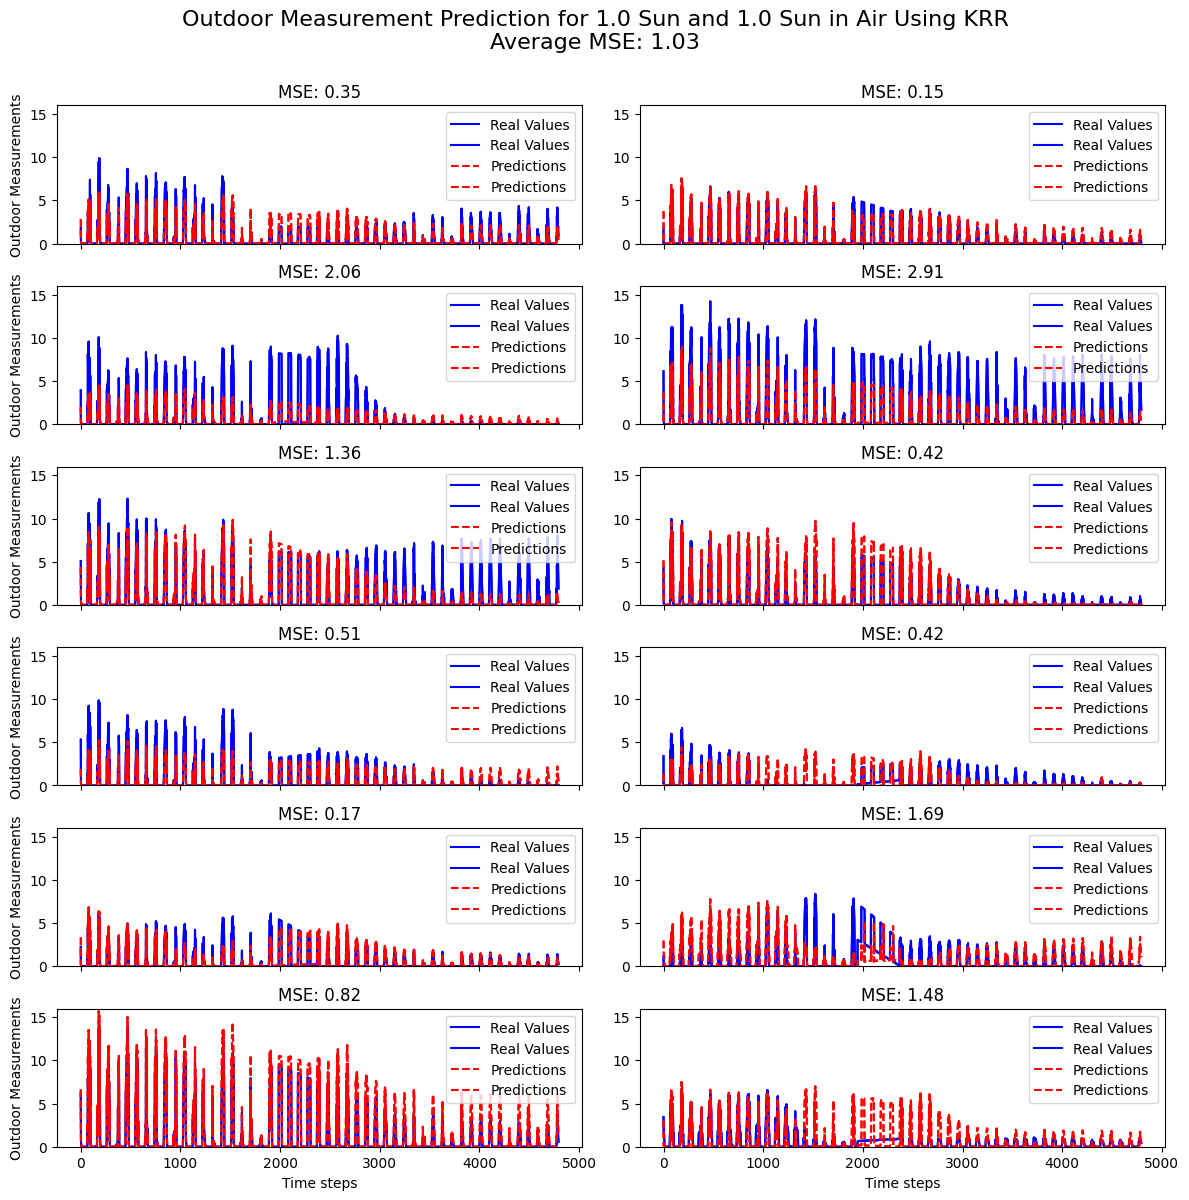

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(0, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(0, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2

axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction for 1.0 Sun and 1.0 Sun in Air Using KRR\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('1.0 and 1.0 sun using krr.pdf')
plt.savefig('1.0 and 1.0 sun using krr.png')
plt.show()